# Import nltk tools

In [681]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Switch area
SUBJECT = 'unit'
# SUBJECT_set_1 for col classify= [ 'brand', 'style', 'item', 'description', 'spec', 'width:', 'weight:', 'position', 'color_way', 'supplier', 'ref', 'qty', 'price/unit', 'unit', ]

VOCAB_SIZE = 900
# If VOCAB_SIZE is great than the row of database, it will cause error and stop the calculating on the step "Create Vocabulary with WORD_ID".

TEST_SIZE = 0.1 # proportion, the size of test_set

# for record the result in the excel file.
RECORD_FILE = 'Matrix_and_Trained-data_records_main-file.csv'

# Remenber to fillout it by manual !!!!!
# The matrix you used in the 010_01_Matrix_Generator, for checking the precision of matrix, 
MATRIX = 'col_classify_matrix_trimed_delete-none-material-col_20200404.csv'

# Wrod processing

In [682]:
data = pd.read_csv('result/Matrix/' + SUBJECT + '_matrix.csv')

* Name the index as "MATERIAL_IDs"
* The matrix must has it unrepeated Id before import to here, show as the "Unnamed: 0".

In [683]:
data.head()

,Unnamed: 0,material,unit
0,0,", scott usa",0
1,1,", scott usa",0
2,2,", scott usa",0
3,3,", scott usa",0
4,4,", scott usa",0


* Change the col "Unnamed: 0" as "MATERIAL_ID"

In [684]:
data.rename( columns = {'Unnamed: 0': 'MATERIAL_ID'}, inplace = True)

In [685]:
data.head()

,MATERIAL_ID,material,unit
0,0,", scott usa",0
1,1,", scott usa",0
2,2,", scott usa",0
3,3,", scott usa",0
4,4,", scott usa",0


* Set the original index as Index

In [686]:
data.set_index('MATERIAL_ID', inplace = True)

In [687]:
data.tail()

,material,unit
MATERIAL_ID,,
3828,", 3.55', '3.5', '3.55', '3.55', '3.5', '0.82',...",1
3829,", 3.5', '3.5', '0.82', '1.6', '0.47', '0.25603...",1
3830,", 3.5', '3.5', '3.5', '0.82', '1.6', '3.3', '0...",1
3831,", 3.5', '3.345', '0.82', '0.84', '1.12', '1.1...",1
3832,", 3.67', '3.5', '3.5', '3.5', '0.82', '1.12', ...",1


## Nltk Function

In [688]:
def nltk_convert(col_of_df):
    '''
    Parameter of this function is a column of a dataFrame.
    
    '''
    # difine Stop words
    stop_words = set(stopwords.words('english'))
    # Difine Stemmer
    stemmer = SnowballStemmer('english')
    
    # converts to lower case and splits up the words
    words = word_tokenize(col_of_df)
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        # if word is not in the stop_words list and is not a alpha.
        if word not in stop_words and word.isalpha():
#             filtered_words.append(stemmer.stem(word))
            filtered_words.append(word)
            
    return filtered_words

* Test the function, with row 0, in column 'material'

In [689]:
nltk_convert(data.at[0, 'material'])

['scott', 'usa']

## Applying to the matrix
* the variable "nested_list" will hold the result.
* It is a series in this moment.

In [690]:
%%time
nested_list = data.material.apply(nltk_convert)

CPU times: user 2.43 s, sys: 146 ms, total: 2.58 s
Wall time: 2.81 s


In [691]:
type(nested_list)

pandas.core.series.Series

## True and False categories
* Exact the index of fabric materials, and non fabric materials

In [692]:
material_ids_ctg_1 = data[data[SUBJECT] == 1].index
material_ids_ctg_0 = data[data[SUBJECT] ==0].index

In [693]:
material_ids_ctg_1

Int64Index([3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752,
            3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763,
            3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774,
            3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785,
            3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796,
            3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807,
            3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818,
            3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829,
            3830, 3831, 3832],
           dtype='int64', name='MATERIAL_ID')

### Get materials back by index
* Exact the strings in col 'material' by the index of doc_ids_fabric

In [694]:
nested_list_ctg_1 = nested_list.loc[material_ids_ctg_1]

In [695]:
nested_list_ctg_1

MATERIAL_ID
3742     [yard]
3743    [meter]
3744     [yard]
3745     [yard]
3746    [meter]
         ...   
3828         []
3829         []
3830         []
3831         []
3832         []
Name: material, Length: 91, dtype: object

* by the index of doc_ids_trim

In [696]:
nested_list_ctg_0 = nested_list.loc[material_ids_ctg_0]

In [697]:
nested_list_ctg_0.shape[0]

3742

## Number of Distinct words
* The Ctg_1

In [698]:
flat_list_ctg_1 =[item for sublist in nested_list_ctg_1 for item in sublist]

In [699]:
ctg_1_words = pd.Series(flat_list_ctg_1).value_counts()

In [700]:
ctg_1_words.shape

(7,)

* The Ctg_0

In [701]:
flat_list_ctg_0 = [item for sublist in nested_list_ctg_0 for item in sublist]

In [702]:
ctg_0_words = pd.Series(flat_list_ctg_0).value_counts()

In [703]:
ctg_0_words.head()

black     2257
pocket    1747
color     1732
label     1609
side      1606
dtype: int64

# Generate Vocabulary
## Top 10 words in Matrix (ctg_1 and ctg_0)

* It is same as function the nltk_convert, the difference is in the end of the funciton, it not append word directly, but word converted by function stemmer.stem.

In [704]:
def stemmered_nltk_convert(col_of_df):
    '''
    Parameter of this function is a column of a dataFrame.
    
    '''
    # difine Stop words
    stop_words = set(stopwords.words('english'))
    # Difine Stemmer
    stemmer = SnowballStemmer('english')
    
    # converts to lower case and splits up the words
    words = word_tokenize(col_of_df)
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        # if word is not in the stop_words list and is not a alpha.
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            
    return filtered_words

In [705]:
%%time
stemmed_nested_list = data.material.apply(stemmered_nltk_convert)

CPU times: user 3.74 s, sys: 135 ms, total: 3.87 s
Wall time: 3.94 s


* Get flat list for all words

In [706]:
flat_stemmed_nested_list = [item for sublist in stemmed_nested_list for item in sublist]

* Turn it to a series

In [707]:
unique_words = pd.Series(flat_stemmed_nested_list).value_counts()

In [708]:
unique_words

black        2281
pocket       2198
tape         1897
zipper       1896
color        1873
             ... 
flame           1
evergreen       1
rococco         1
aaran           1
sublim          1
Length: 1458, dtype: int64

* Set the size of vacabulary
* This size need to be tested a lot, in this cace, follow the e-mail processing lecture, I takes 10 % of total particular words

In [709]:
VOCAB_SIZE

900

In [710]:
frequent_words = unique_words[0:VOCAB_SIZE]

In [711]:
print('Most common words: \n', frequent_words[:10])

Most common words: 
 black     2281
pocket    2198
tape      1897
zipper    1896
color     1873
label     1849
side      1659
number    1523
shell     1491
seam      1073
dtype: int64


## Create Vocabulary with WORD_ID

In [712]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index = word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,black
1,pocket
2,tape
3,zipper
4,color


* Save the vocabulary

In [713]:
vocab.to_csv('result/Trained Data/Vocabulary/'+SUBJECT+'_vocabulary.csv')

* Test the any word to see if it is in the vocabulary

In [714]:
'hangtag' in set(vocab.VOCAB_WORD)

True

## Search out the material with most token

In [715]:
clean_material_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr wrods in the longest material:', max(clean_material_lengths))

Nr wrods in the longest material: 2510


In [716]:
print('Material position in the list', np.argmax(clean_material_lengths))

Material position in the list 870


In [717]:
stemmed_nested_list[np.argmax(clean_material_lengths)]

['nitro',
 'men',
 'jacket',
 'sampl',
 'size',
 'larg',
 'winter',
 'contractor',
 'soluna',
 'number',
 'date',
 'creat',
 'name',
 'summit',
 'packabl',
 'date',
 'revis',
 'block',
 'base',
 'powel',
 'fit',
 'mtn',
 'fit',
 'seal',
 'fulli',
 'seam',
 'tape',
 'fit',
 'regular',
 'no',
 'insul',
 'target',
 'fob',
 'colorway',
 'fabric',
 'refer',
 'number',
 'locat',
 'content',
 'refer',
 'number',
 'locat',
 'content',
 'tape',
 'refer',
 'number',
 'locat',
 'content',
 'refer',
 'number',
 'locat',
 'content',
 'men',
 'jacket',
 'sampl',
 'size',
 'larg',
 'winter',
 'contractor',
 'soluna',
 'number',
 'date',
 'creat',
 'name',
 'summit',
 'packabl',
 'date',
 'revis',
 'block',
 'base',
 'powel',
 'fit',
 'mtn',
 'fit',
 'seal',
 'fulli',
 'seam',
 'tape',
 'fit',
 'regular',
 'no',
 'insul',
 'target',
 'fob',
 'refer',
 'number',
 'locat',
 'amount',
 'zipper',
 'pull',
 'refer',
 'number',
 'locat',
 'amount',
 'trim',
 'refer',
 'number',
 'locat',
 'amount',
 'refer'

# Generate Features & Spare Matrix
### Creating a DataFrame with one word per column

In [718]:
type(stemmed_nested_list)

pandas.core.series.Series

In [719]:
stemmed_nested_list

MATERIAL_ID
0       [scott, usa]
1       [scott, usa]
2       [scott, usa]
3       [scott, usa]
4       [scott, usa]
            ...     
3828              []
3829              []
3830              []
3831              []
3832              []
Name: material, Length: 3833, dtype: object

In [720]:
type(stemmed_nested_list.tolist())

list

In [721]:
word_col_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_col_df

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
0,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,scott,usa,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3828,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3829,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3830,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3831,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


## Traning Set and Test Set
* Must import the method "train_test_split()" from sklearn

In [722]:
X_train, X_test, y_train, y_test = train_test_split(word_col_df, data[SUBJECT],
                                                    test_size = TEST_SIZE)

In [723]:
print('Nr of traning samples', X_train.shape[0])
print('Fraction of traning set', X_train.shape[0] / word_col_df.shape[0])

Nr of traning samples 3449
Fraction of traning set 0.8998173754239499


In [724]:
X_train.index.name = X_test.index.name = 'MATERIAL_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
2905,black,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2064,seam,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3725,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3154,libolon,time,zipper,pahio,pahio,pahio,pahio,pahio,pahio,zipper,...,None,None,None,None,None,None,None,None,None,None
3326,ykk,dalh,lock,ykk,dadhr,diecast,wire,lock,ykk,dadhr,...,None,None,None,None,None,None,None,None,None,None


In [725]:
y_train.head()

MATERIAL_ID
2905    0
2064    0
3725    0
3154    0
3326    0
Name: unit, dtype: int64

## Sparse Matrix for the traning data
* Get vocabulary turned as an Index:

In [726]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index

Index(['black', 'pocket', 'tape', 'zipper', 'color', 'label', 'side', 'number',
       'shell', 'seam',
       ...
       'cleaer', 'polyestr', 'sestrier', 'wi', 'co', 'shorter', 'jean',
       'confirm', 'blair', 'dye'],
      dtype='object', name='VOCAB_WORD', length=900)

In [727]:
y_train.shape[0]

3449

### Sparse Matrix Function

In [728]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns a sparse matrix as dataframe
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'MATERIAL_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
                
    return pd.DataFrame(dict_list)

## Training data
### Applying to the traning set

In [729]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 43.9 s, sys: 132 ms, total: 44 s
Wall time: 44.3 s


In [730]:
sparse_train_df

,LABEL,MATERIAL_ID,OCCURENCE,WORD_ID
0,0,2905,1,0
1,0,2064,1,9
2,0,3154,1,571
3,0,3154,1,146
4,0,3154,1,3
...,...,...,...,...
83041,0,3616,1,119
83042,0,3616,1,263
83043,0,3616,1,275
83044,0,3616,1,119


In [731]:
sparse_train_df.shape

(83046, 4)

### Group by the DOC_ID

In [732]:
train_grouped = sparse_train_df.groupby(['MATERIAL_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped

OCCURENCE
MATERIAL_ID WORD_ID LABEL           
0           478     0              1
            481     0              1
1           478     0              1
            481     0              1
2           478     0              1
...                              ...
3822        297     1              1
3823        480     1              1
3824        480     1              1
3825        480     1              1
3826        480     1              1

[27078 rows x 1 columns]

* Distribute the DOC_ID to each row

In [733]:
train_grouped = train_grouped.reset_index()

In [734]:
train_grouped

,MATERIAL_ID,WORD_ID,LABEL,OCCURENCE
0,0,478,0,1
1,0,481,0,1
2,1,478,0,1
3,1,481,0,1
4,2,478,0,1
...,...,...,...,...
27073,3822,297,1,1
27074,3823,480,1,1
27075,3824,480,1,1
27076,3825,480,1,1


### Save Traning Data
* We save it as a txt file, with only numbers of the IDs, Occurances, label, as showed above. 

In [735]:
np.savetxt('result/Trained Data/' + SUBJECT + '_sparse_traning_data', train_grouped, fmt = '%d')

## Test Data
* The way to create it is basically same way as treating traning data.

In [736]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,2500,2501,2502,2503,2504,2505,2506,2507,2508,2509
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3131,singtex,sourc,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
315,airblast,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2401,pseudo,anti,silver,slider,dtm,teeth,dtm,tape,anti,silver,...,None,None,None,None,None,None,None,None,None,None
1989,hood,front,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3217,tsgs,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [737]:
y_test.head()

MATERIAL_ID
3131    0
315     0
2401    0
1989    0
3217    0
Name: unit, dtype: int64

In [738]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 4.76 s, sys: 19 ms, total: 4.78 s
Wall time: 4.83 s


In [739]:
test_grouped = sparse_test_df.groupby(['MATERIAL_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,MATERIAL_ID,WORD_ID,LABEL,OCCURENCE
0,3,478,0,1
1,3,481,0,1
2,18,726,0,1
3,21,726,0,1
4,23,898,0,1


In [740]:
np.savetxt('result/Trained Data/' + SUBJECT + '_sparse_test_data', test_grouped, fmt = '%d')

# Full Matrix
* Create anempty df first

### Columns of Full Matrix
* The empty df with column 'DOC_ID', in the case I use 'MATERIAL_ID'
* Second column is 'CATEGORY'
* The rest column is number from 0 to the number of words in vocabulary.

In [741]:
column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))

### Rows of Full Matrix
* If consists of Material_ID in Training Data
* Numpy method np.unique() will take a number 1 time, even it occurs many time in the Traning Data.
* Import the traning data we saved as txt

In [742]:
TRANING_DATA = 'result/Trained Data/' + SUBJECT + '_sparse_traning_data'

* Open it by Numpy

In [743]:
sparse_train_data = np.loadtxt(TRANING_DATA, delimiter = ' ', dtype=int)

In [744]:
index_names = np.unique(sparse_train_data[:, 0])

### Form the Data Frame
* Create an empty df, columned by column_names, indexed by index_names
* Fullfill all the cell with value "0"

In [745]:
full_train_data = pd.DataFrame(index= index_names, columns = column_names)
full_train_data.fillna(value = 0, inplace = True)
full_train_data.shape

(2463, 902)

## Make a Full matrix function

In [746]:
def make_full_matrix(sparse_matrix, nr_words, doc_idx = 0, word_idx = 1, cat_idx = 2, freq_idx = 3):
    column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
    doc_id_names = np.unique(sparse_matrix[:,0])
    full_matrix = pd.DataFrame(index = doc_id_names, columns = column_names)
    full_matrix.fillna(value=0, inplace=True)
    
    for i in range(sparse_matrix.shape[0]):
        doc_nr = sparse_matrix[i][doc_idx]
        word_id = sparse_matrix[i][word_idx]
        label = sparse_matrix[i][cat_idx]
        occurrence = sparse_matrix[i][freq_idx]
        
        full_matrix.at[doc_nr, 'MATERIAL_ID'] = doc_nr
        full_matrix.at[doc_nr, 'CATEGORY'] = label
        full_matrix.at[doc_nr, word_id] = occurrence
        
    full_matrix.set_index('MATERIAL_ID', inplace = True)
    return full_matrix

In [747]:
%%time
full_train_data = make_full_matrix(sparse_train_data, VOCAB_SIZE)

CPU times: user 1.62 s, sys: 32.1 ms, total: 1.66 s
Wall time: 1.56 s


In [748]:
full_train_data

,CATEGORY,0,1,2,3,4,5,6,7,8,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3822,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3823,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3824,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Probability of Category_1 in train_data

In [749]:
full_train_data.CATEGORY.size

2463

In [750]:
full_train_data.CATEGORY.sum()

58

In [751]:
prob_ctg_1 = full_train_data.CATEGORY.sum() / full_train_data.CATEGORY.size
print('Probability  of ' + SUBJECT +' is', prob_ctg_1)

Probability  of unit is 0.023548518067397484


In [752]:
prob_ctg_1

0.023548518067397484

In [753]:
prob_ctg_1_in_train_data = pd.DataFrame({'prob_ctg_1_train_set':[prob_ctg_1]})

In [754]:
prob_ctg_1_in_train_data.to_csv('result/Trained Data/Train_set/' + SUBJECT + '_prob_ctg_1_in_train_data')

# Count each material in train_data have how many tokens
## Full train Features
* It is very simple. The whole df of train_data without the column 'CATEGORY' is the Full train Features
* Create a new df with no column 'CATEGORY'

In [755]:
full_train_features = full_train_data.loc[:, full_train_data.columns != 'CATEGORY']

In [756]:
full_train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [757]:
# full_train_features[1249].sum()

### Number of tokens each material has in train_data
* We added up all values in row direction, to get sum of each row 

In [758]:
material_train_data = full_train_features.sum(axis = 1) 
material_train_data.shape # Show how many materials in train_data

(2463,)

In [759]:
material_train_data # Show how many words each material in train_data has

MATERIAL_ID
0       2
1       2
2       2
4       2
5       2
       ..
3822    1
3823    1
3824    1
3825    1
3826    1
Length: 2463, dtype: int64

* Total number of words in train_data

In [760]:
total_words_train_data = material_train_data.sum()
total_words_train_data

83046

#### Token of ctg_1 in train_data
* Number of particular words of category 1, in train_data
* The word can be called "token"

In [761]:
ctg_1_in_train_data = material_train_data[full_train_data.CATEGORY == 1]
ctg_1_in_train_data.shape
# 1379 materials in train_data is fabric

(58,)

In [762]:
ctg_1_token_in_train_data = ctg_1_in_train_data.sum()
ctg_1_token_in_train_data
# The total words in Category 1, the fabric, in the train_data

58

#### Token of trim in train_data
* Number of particular words of category 0, the trim, in train_data

In [763]:
ctg_0_in_train_data = material_train_data[full_train_data.CATEGORY == 0]
ctg_0_in_train_data.shape 
# Total, 5026 materials in train_data is trim

(2405,)

In [764]:
ctg_0_token_in_train_data = ctg_0_in_train_data.sum()
ctg_0_token_in_train_data 
# Total words in Category 0, the trim, in the train_data

82988

### Average number of words in fabric and trim
* In this case, CATEGORY 1 is fabric, 0 is trim

In [765]:
print('Average nr of words in ctg_1 {:.0f}'.format(ctg_1_token_in_train_data / ctg_1_in_train_data.shape[0]))
print('Average nr of words in ctg_0 {:.0f}'.format(ctg_0_token_in_train_data / ctg_0_in_train_data.shape[0]))

Average nr of words in ctg_1 1
Average nr of words in ctg_0 35


In [766]:
# The snippet is for testing if the calculating get problem.
# The answer should eaquls to 0
material_train_data.shape[0] - ctg_1_in_train_data.shape[0] - ctg_0_in_train_data.shape[0]

0

# Count each token's frequency in both Category
## Full train Features of ctg_1
* It is very simple. The df of train_data in 'CATEGORY'1, and without the column 'CATEGORY' is the Full train Features of Fabric

In [767]:
ctg_1_full_train_features = full_train_features.loc[full_train_data.CATEGORY == 1]

In [768]:
ctg_1_full_train_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3747,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3748,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3750,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3751,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3753,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Full train feature of trim

In [769]:
ctg_0_full_train_features = full_train_features.loc[full_train_data.CATEGORY == 0]

In [770]:
ctg_0_full_train_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Frequency of tokens in fabric in train_data
* We add up all value in column direction to get sum of each column.
* The sum represents each word occurs how many time in the category 1, the fabric.
* It is possible that some words in vocabulary never appear in this category, so we need "+ 1" to this token. Since later we'll divide it to get the percentage, if you divide 0, it may cause error.

In [771]:
summed_ctg_1_tokens_in_train_data = ctg_1_full_train_features.sum(axis = 0) + 1

In [772]:
summed_ctg_1_tokens_in_train_data

0      1
1      1
2      1
3      1
4      1
      ..
895    1
896    1
897    1
898    1
899    1
Length: 900, dtype: int64

### Frequency of tokens in trim in train_data
* The way treat it as treating with fabric

In [773]:
summed_ctg_0_tokens_in_train_data = ctg_0_full_train_features.sum(axis = 0) + 1

In [774]:
summed_ctg_0_tokens_in_train_data

0      2028
1      2096
2      1700
3      1690
4      1648
       ... 
895       6
896       6
897       6
898       5
899       6
Length: 900, dtype: int64

# Probability of tokens
* Why here not only divided the frequency of each token by total tokens but also the size of vocabulary? It is becasue we add "+ 1" for each word when counting frequency, so add the size of vocabulary is for balancing the number back.

## P of Training Set 
### Probability of tokens in fabric in train_data
* ### P( Token | ctg_1 )
* Take the each summed up occurance divided by the total nubmer of token in category of fabric.

In [775]:
prob_tokens_ctg_1_train_set = summed_ctg_1_tokens_in_train_data / (ctg_1_token_in_train_data + VOCAB_SIZE)

In [776]:
ctg_1_token_in_train_data

58

In [777]:
prob_tokens_ctg_1_train_set

0      0.001044
1      0.001044
2      0.001044
3      0.001044
4      0.001044
         ...   
895    0.001044
896    0.001044
897    0.001044
898    0.001044
899    0.001044
Length: 900, dtype: float64

### Probability of tokens in trim in train_data
* ### P( Token | ctg_0 )

In [778]:
prob_tokens_ctg_0_train_set = summed_ctg_0_tokens_in_train_data / (ctg_0_token_in_train_data + VOCAB_SIZE)

In [779]:
prob_tokens_ctg_0_train_set

0      0.024175
1      0.024986
2      0.020265
3      0.020146
4      0.019645
         ...   
895    0.000072
896    0.000072
897    0.000072
898    0.000060
899    0.000072
Length: 900, dtype: float64

* Check if the number correct.
* The answer should be "1"

In [780]:
prob_tokens_ctg_0_train_set.sum()

1.0

* Test for the prob

In [781]:
check = prob_tokens_ctg_1_train_set[20] > prob_tokens_ctg_0_train_set[20]
check

False

### Probability of tokens in train_data
* ### P (Token)

In [782]:
prob_tokens_all_train_set = full_train_features.sum(axis = 0) / total_words_train_data

In [783]:
prob_tokens_all_train_set

0      0.024408
1      0.025227
2      0.020459
3      0.020338
4      0.019832
         ...   
895    0.000060
896    0.000060
897    0.000060
898    0.000048
899    0.000060
Length: 900, dtype: float64

In [784]:
prob_tokens_all_train_set.sum()

1.0

### Save the trained Model
* P( Token | ctg_1 )
* P( Token | ctg_0 )
* P ( Token )

In [785]:
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_ctg_1_in_train_data' ,prob_tokens_ctg_1_train_set)
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_ctg_0_in_train_data', prob_tokens_ctg_0_train_set)
np.savetxt('result/Trained Data/Train_set/' + SUBJECT + '_prob_tokens_all_in_train_data', prob_tokens_all_train_set)

## P of Test Set
### Probability of tokens in trim in train_data
* ### P( Token | ctg_0 )

* Start from Sparse Matrix of test_set
* Trun the Sparse Matrix to Full Matrix
* Get the number of word of material by summing each row of Full Matrix
* Get the frequency of each word by summing each column of Full Matrix
* Get all this result from test set : P ( Token | ctg_1 ), P (Token | ctg_0 ), P ( Token ) 
 

### Full matrix of test data
#### Import test data Sparse Matrix

In [786]:
TEST_DATA = 'result/Trained Data/' + SUBJECT + '_sparse_test_data'
sparse_test_data = np.loadtxt(TEST_DATA, delimiter = ' ', dtype = int )

#### Create a empty Full Matrix
* Column and row of Full Matrix

In [787]:
column_names = ['MATERIAL_ID'] + ['CATEGORY'] + list(range(0, VOCAB_SIZE))
index_names = np.unique(sparse_test_data[:, 0]) # 1 material_id only for 1 row, without duplicated

#### The custom function make_full_matrix
* empty dataFrame for Full matrix 
* Filled the values from sparse matrix by column match to WORD_ID, the row match to MATERIAL_ID

In [788]:
%%time
full_test_data = make_full_matrix(sparse_test_data, VOCAB_SIZE) 

CPU times: user 591 ms, sys: 11.1 ms, total: 602 ms
Wall time: 823 ms


In [789]:
full_test_data

,CATEGORY,0,1,2,3,4,5,6,7,8,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3774,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Probability in test data
#### Ctg_1

In [790]:
full_test_data.CATEGORY.size

267

In [791]:
full_test_data.CATEGORY.sum()

7

In [792]:
prob_ctg_1_test_data = full_test_data.CATEGORY.sum() / full_test_data.CATEGORY.size
print('Probability of ctg_1 in test_set', prob_ctg_1_test_data)

Probability of ctg_1 in test_set 0.026217228464419477


### Full Features of test_set

In [793]:
full_test_features = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']

In [794]:
full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Number of tokens each material has in test_data

In [795]:
material_test_data = full_test_features.sum(axis = 1)
material_test_data[:5]

MATERIAL_ID
3     2
18    1
21    1
23    1
54    1
dtype: int64

* Total number of words in test_data

In [796]:
total_words_test_data = material_test_data.sum()
total_words_test_data

8065

#### Token of ctg_1 in test_data

In [797]:
ctg_1_in_test_data = material_test_data[full_test_data.CATEGORY == 1]
ctg_1_in_test_data.shape

(7,)

In [798]:
ctg_1_token_in_test_data = ctg_1_in_test_data.sum()
ctg_1_token_in_test_data

7

#### Token of ctg_0 in test_data

In [799]:
ctg_0_in_test_data = material_test_data[full_test_data.CATEGORY == 0]
ctg_0_in_test_data.shape

(260,)

In [800]:
ctg_0_token_in_test_data = ctg_0_in_test_data.sum()
ctg_0_token_in_test_data

8058

#### Average number of words in fabric and trim in test_data

In [801]:
print('Average nr of words in ctg_1 {:.0f}'.format(ctg_1_token_in_test_data / ctg_1_in_test_data.shape[0]))
print('Average nr of words in ctg_0 {:.0f}'.format(ctg_0_token_in_test_data / ctg_0_in_test_data.shape[0]))

Average nr of words in ctg_1 1
Average nr of words in ctg_0 31


### Frequency of tokens in test_data
* Full feature of ctg_1 in test_data

In [802]:
ctg_1_full_test_features = full_test_features.loc[full_test_data.CATEGORY == 1]
ctg_1_full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3766,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3788,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3809,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* Full feature of ctg_0 in test_data

In [803]:
ctg_0_full_test_features = full_test_features.loc[full_test_data.CATEGORY == 0]
ctg_0_full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,0,2,0,0,0,0,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3632,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Frequency of tokens in ctg_1 in test_data

In [804]:
summed_ctg_1_tokens_in_test_data = ctg_1_full_test_features.sum(axis = 0) +1 
summed_ctg_1_tokens_in_test_data

0      1
1      1
2      1
3      1
4      1
      ..
895    1
896    1
897    1
898    1
899    1
Length: 900, dtype: int64

#### Frequency of tokens in ctg_0 in test_data

In [805]:
summed_ctg_0_tokens_in_test_data = ctg_0_full_test_features.sum(axis = 0) +1 
summed_ctg_0_tokens_in_test_data

0      255
1      104
2      199
3      208
4      227
      ... 
895      1
896      1
897      1
898      2
899      1
Length: 900, dtype: int64

## P of Test Set
* ### P( Token | ctg_1 )

In [806]:
prob_tokens_ctg_1_test_set = summed_ctg_1_tokens_in_test_data / (ctg_1_token_in_test_data + VOCAB_SIZE)

In [807]:
prob_tokens_ctg_1_test_set

0      0.001103
1      0.001103
2      0.001103
3      0.001103
4      0.001103
         ...   
895    0.001103
896    0.001103
897    0.001103
898    0.001103
899    0.001103
Length: 900, dtype: float64

* ### P( Token | ctg_0 )

In [808]:
prob_tokens_ctg_0_test_set = summed_ctg_0_tokens_in_test_data / (ctg_0_token_in_test_data + VOCAB_SIZE)

In [809]:
prob_tokens_ctg_0_test_set

0      0.028466
1      0.011610
2      0.022215
3      0.023219
4      0.025340
         ...   
895    0.000112
896    0.000112
897    0.000112
898    0.000223
899    0.000112
Length: 900, dtype: float64

* ### P( Token )

In [810]:
prob_tokens_all_test_set = full_test_features.sum(axis = 0) / total_words_test_data

In [811]:
prob_tokens_all_test_set

0      0.031494
1      0.012771
2      0.024551
3      0.025666
4      0.028022
         ...   
895    0.000000
896    0.000000
897    0.000000
898    0.000124
899    0.000000
Length: 900, dtype: float64

In [812]:
prob_tokens_all_test_set.sum()

0.9999999999999999

### Save the test Model
* P( Token | ctg_1 )
* P( Token | ctg_0 )
* P ( Token )

In [813]:
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_ctg_1_in_test_data' ,prob_tokens_ctg_1_test_set)
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_ctg_0_in_test_data', prob_tokens_ctg_0_test_set)
np.savetxt('result/Trained Data/Test_set/' + SUBJECT + '_prob_tokens_all_in_test_data', prob_tokens_all_test_set)

# Joint probability
* Get the the full feature of test_set
* Get full target of test_set
* Take each cell in Full features of test_set times the probability of fabric in train_set

### Full feature of test_set

In [814]:
full_test_features = full_test_data.loc[:, full_test_data.columns != 'CATEGORY']
full_test_features

,0,1,2,3,4,5,6,7,8,9,...,890,891,892,893,894,895,896,897,898,899
MATERIAL_ID,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
54,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3768,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3774,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Full target of test_set

In [815]:
full_test_target = full_test_data.CATEGORY
full_test_target

MATERIAL_ID
3       0
18      0
21      0
23      0
54      0
       ..
3768    1
3774    1
3778    1
3788    1
3809    1
Name: CATEGORY, Length: 267, dtype: int64

### Probability of ctg_1 of Test_set
* The frequancy of tokens in test_set x The probability of tokens in train_set

In [816]:
prob_tokens_ctg_1_train_set

0      0.001044
1      0.001044
2      0.001044
3      0.001044
4      0.001044
         ...   
895    0.001044
896    0.001044
897    0.001044
898    0.001044
899    0.001044
Length: 900, dtype: float64

In [817]:
joint_pty = full_test_features.dot(prob_tokens_ctg_1_train_set)
joint_pty

MATERIAL_ID
3       0.002088
18      0.001044
21      0.001044
23      0.001044
54      0.001044
          ...   
3768    0.016701
3774    0.016701
3778    0.016701
3788    0.035491
3809    0.035491
Length: 267, dtype: float64

# Prior
* Prior is the percentage of event that we get from the datas.
* If we want to count the fabric, Prior in this case is the probability of fabric.
* numbers of fabric / total material.

P( ctg_1 | documents )  = 
P( documentsl | ctg_1 ) * P( ctg_1) / P( document )


# Joint probability in log format
* Ctg_1 joint prob in log format

In [818]:
joint_log_ctg_1 = full_test_features.dot(np.log(prob_tokens_ctg_1_train_set) - np.log(prob_tokens_all_train_set)) + np.log(prob_ctg_1) 

In [819]:
joint_log_ctg_1[:5]

MATERIAL_ID
3    NaN
18   NaN
21   NaN
23   NaN
54   NaN
dtype: float64

* Ctg_0 joint prob in log format

In [820]:
joint_log_ctg_0 = full_test_features.dot(np.log(prob_tokens_ctg_0_train_set) - np.log(prob_tokens_all_train_set)) + np.log(1 - prob_ctg_1) 

In [821]:
joint_log_ctg_0[:5]

MATERIAL_ID
3    NaN
18   NaN
21   NaN
23   NaN
54   NaN
dtype: float64

## Simplify Joint probability in log format
* Only in the comparison situation can take away the snippet, in other condition, it will lead to a wrong result.

In [822]:
joint_log_ctg_1 = full_test_features.dot(np.log(prob_tokens_ctg_1_train_set)) + np.log(prob_ctg_1)
joint_log_ctg_0 = full_test_features.dot(np.log(prob_tokens_ctg_0_train_set)) + np.log(1-prob_ctg_1)

# Prediction

In [823]:
prediction = joint_log_ctg_1 > joint_log_ctg_0

* Check if the prediction got wrong.
* If the joint_log_fabric bigger than joint_log_trim, show true. times 1 is for the boolean tured into numbrer 0 or 1.
* If the material shows 1 means it is have more possibility as a fabric.
* Then we compare the category list of the test_set to see if the prediction is same as the category of test_set

In [824]:
joint_log_ctg_1.min()

-3230.22714803388

In [825]:
prediction[-5:]*1

MATERIAL_ID
3768    1
3774    1
3778    1
3788    1
3809    1
dtype: int64

In [826]:
full_test_target[-5:]

MATERIAL_ID
3768    1
3774    1
3778    1
3788    1
3809    1
Name: CATEGORY, dtype: int64

### Check the accuracy of this model

In [827]:
correct_materials = (full_test_target == prediction).sum()
print('Does classified correctly', correct_materials)
num_materials_wrong = full_test_features.shape[0] - correct_materials
print('Does classfied incorrectly', num_materials_wrong)

Does classified correctly 258
Does classfied incorrectly 9


### Accuracy %

In [828]:
correct_materials / len(full_test_features)

0.9662921348314607

# Decision Boundary
## Visualizing the results

In [829]:
yaxis_label = 'P(X | ' + SUBJECT + ')'
xaxis_label = 'P(X | Others)'

linedata = np.linspace(start = -14000, stop = 1, num = 1000)

#Chart Styling
sns.set_style('whitegrid')
labels = 'Actual Category'

summary_df = pd.DataFrame({xaxis_label: joint_log_ctg_1, 
                           yaxis_label: joint_log_ctg_0, 
                           labels: full_test_target})

## The Decision Boundary
* Since we transfored both joint probability, fabric and trim, into log format, so the value will be minus.

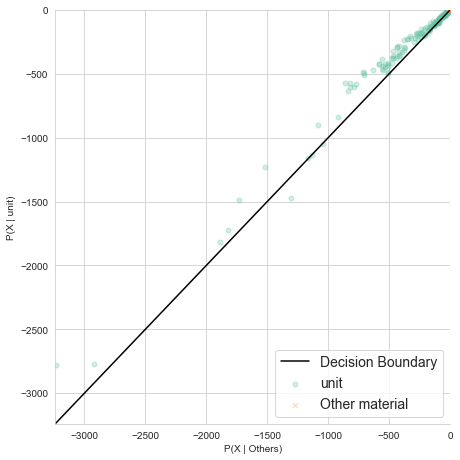

In [830]:
sns.lmplot(x = xaxis_label, y = yaxis_label, 
           data =summary_df, height = 6.5, 
           fit_reg=False, legend=False, scatter_kws={'alpha': 0.3, 's': 25}, 
           hue = labels, markers = ['o', 'x'], palette = 'Set2' )

plt.xlim([joint_log_ctg_1.min() - 10, 1])
plt.ylim([joint_log_ctg_1.min() - 10, 1])

plt.plot(linedata, linedata, color = 'black')

plt.legend(('Decision Boundary', SUBJECT , 'Other material'), 
           loc='lower right', fontsize = 14)

plt.show()

# False Positives and False Negatives
* The function up.unique() shows the nubmer of value 0 is 2347, the value 1 is 650.

In [831]:
np.unique(prediction, return_counts = True)

(array([False,  True]), array([251,  16]))

### True positives
* It shows, the document is 1, the True, and model also predicts it as 1, True.
* In this case, the material is fabric in CATEGORY, and the prediction also say it is fabric.

In [832]:
true_pos = (y_test == 1)&(prediction == 1)

In [833]:
true_pos.sum()

7

### True negatives
* It shows, the document is 0, the False, and the model also predicts it as 0, False.
* In this case, the material is actually trim in CATEGORY, and the prediction also say it is trim.

In [834]:
true_neg = (y_test == 0)&(prediction ==0)

In [835]:
true_neg.sum()

251

### False positives
* It shows, the document is 0, the False, and model predicts it as 1, True.
* In this case, the material is trim in CATEGORY, and yet prediction says it is fabric.

In [836]:
false_pos = (y_test == 0)&(prediction ==1)

In [837]:
false_pos.sum()

9

### False negtives
* It shows, the document is 1, the True, and model predicts it as 0, False.
* In this case, the material is fabric in CATEGORY, and yet prediction says it is trim.

In [838]:
false_neg = (y_test == 1)&(prediction == 0)

In [839]:
false_neg.sum()

0

In [840]:
(y_test == 1).sum()

8

# Recall Score
* It tells how much the model will omit the document. More the value close to 1, less the model will omit to fit document.
* It tells the reliability of the model, in other words, how much the model resemble to the relevant documents.
* More the value close to 1, less the model will omit any document.

In [841]:
recall_score = true_pos.sum() / (y_test == 1).sum()
print('Recall score is {:.2%}'. format(recall_score))

Recall score is 87.50%


# Precision Score
* It tells how precisely the model predicting.

In [842]:
precision_score = true_pos.sum() / (true_pos.sum() + false_pos.sum())
print('Precision score is {:.3}'.format(precision_score))

Precision score is 0.438


# F-Score or F1 Score
* Closer the value to 1, better the model is.

In [843]:
f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score)
print('F Score is {:.2}'.format(f1_score))

F Score is 0.58


# Record the result in a CSV file
* Record the result, so I can check the precision of the matrix

In [844]:
record_file = pd.read_csv(RECORD_FILE, encoding = 'ISO-8859-1', index_col = 'RECORD_ID')

In [845]:
record_file.tail()

,Csv,Rows,SUBJECT,VOCAB_SIZE,Test_size,True_Positives,True_Negatives,False_Positives,False_Negatives,TRUE_in y_test,Recall_Score,Precision_Score,F1-Score
RECORD_ID,,,,,,,,,,,,,
124,col_classify_matrix_trimed_delete-none-materia...,3820,color_way,900,0.1,75,186,3,0,100,75.00%,0.962,0.84
125,col_classify_matrix_trimed_delete-none-materia...,3820,item,900,0.1,22,220,11,16,38,57.89%,0.667,0.62
126,col_classify_matrix_trimed_delete-none-materia...,3820,position,900,0.1,44,231,5,4,49,89.80%,0.898,0.90
127,col_classify_matrix_trimed_delete-none-materia...,3820,spec,900,0.1,13,236,9,0,27,48.15%,0.591,0.53
128,col_classify_matrix_trimed_delete-none-materia...,3820,qty,900,0.1,5,270,4,0,16,31.25%,0.556,0.40


In [846]:
# For record in cxcel file
new_record = {
    'Csv':MATRIX,
    'Rows':data.shape[0],
    'SUBJECT':SUBJECT,
    'VOCAB_SIZE':VOCAB_SIZE,
    'Test_size':TEST_SIZE,
    'True_Positives':true_pos.sum(),
    'True_Negatives':true_neg.sum(),
    'False_Positives':false_pos.sum(),
    'False_Negatives':false_neg.sum(),
    'TRUE_in y_test':(y_test == 1).sum(),
    'Recall_Score':'{:.2%}'. format(recall_score),
    'Precision_Score':'{:.3}'.format(precision_score),
    'F1-Score':'{:.2}'.format(f1_score),
}

In [847]:
# the attribute 'name' of the df method .append in this case represents the index column 'RECORD_ID'
record_file = record_file.append(pd.Series(new_record, name = record_file.shape[0]), ignore_index = False)

In [848]:
record_file.tail()

,Csv,Rows,SUBJECT,VOCAB_SIZE,Test_size,True_Positives,True_Negatives,False_Positives,False_Negatives,TRUE_in y_test,Recall_Score,Precision_Score,F1-Score
RECORD_ID,,,,,,,,,,,,,
125,col_classify_matrix_trimed_delete-none-materia...,3820,item,900,0.1,22,220,11,16,38,57.89%,0.667,0.62
126,col_classify_matrix_trimed_delete-none-materia...,3820,position,900,0.1,44,231,5,4,49,89.80%,0.898,0.9
127,col_classify_matrix_trimed_delete-none-materia...,3820,spec,900,0.1,13,236,9,0,27,48.15%,0.591,0.53
128,col_classify_matrix_trimed_delete-none-materia...,3820,qty,900,0.1,5,270,4,0,16,31.25%,0.556,0.4
129,col_classify_matrix_trimed_delete-none-materia...,3833,unit,900,0.1,7,251,9,0,8,87.50%,0.438,0.58


In [849]:
# Add time set for record file name.
import datetime
now = datetime.datetime.now()
today = now.strftime('%Y-%m-%d')
print(today)

2020-04-10


## Save the record file
* Here we save 2 copies, 1 for the main file, it will be covered and reused for next time.
* The other is a file with the date of today as backup saving in the directory 'record'

In [850]:
# Save a copy to the directory 'record'
record_file.to_csv('record/Matrix_and_Trained-data_records_'+ today +'.csv')
# Save and cover the main file.
record_file.to_csv('Matrix_and_Trained-data_records_main-file.csv')